In [1]:
import sys

In [2]:
sys.path.append('/home/ec2-user/SageMaker/')
sys.path.append('/home/ec2-user/SageMaker/bokeh_interactive/')
sys.path.append('/home/ec2-user/SageMaker/bokeh_interactive/tools/')
sys.path.append('/home/ec2-user/SageMaker/bokeh_interactive/tools/wrangle_data.py')
sys.path.append("tools/wrangle_data.py")
sys.path.append("/Users\mekho\Documents\PycharmProjects\Quiz_Food_LinkedIn")

In [3]:
from tools.wrangle_data import parse_community_data

In [48]:
import pandas as pd
import seaborn as sns
import numpy as np
import multiprocessing as mp
from multiprocessing import Pool
import pickle


In [5]:
mp.cpu_count()

8

In [6]:
df_community = pd.read_csv("../data/Community_Context/nov18pub.dat", header=None)


works = [df_community.values.squeeze()[i] for i in range(len(df_community.values.squeeze()))]


In [7]:
pool = Pool(processes=4)

In [8]:
results = pool.map(parse_community_data, works)

In [9]:
df_results = pd.DataFrame(results)

In [10]:
df_results.shape

(143050, 8)

In [11]:
df_results.columns

Index(['interview_type', 'voting_type', 'registered_type', 'age_range',
       'year_of_interview', 'state_code', 'metropolitan_code', 'county_code'],
      dtype='object')

In [12]:
df_results.voting_type.value_counts()

-1    54301
1     48337
2     25606
-9    11626
-2     1800
-3     1380
Name: voting_type, dtype: int64

In [13]:
df_results.interview_type.value_counts()

 1    122744
 3     10141
 2      9642
 4       523
Name: interview_type, dtype: int64

In [14]:
df_results.age_range.value_counts()

 2    99942
 1    22352
-1    20306
 3      450
Name: age_range, dtype: int64

## Remove Unqualified Interviewees

In [15]:
df_results_filtered = df_results.loc[df_results.voting_type != '-1', :]

In [16]:
df_results_filtered.shape

(88749, 8)

In [17]:
df_results_filtered.head(2)

,interview_type,voting_type,registered_type,age_range,year_of_interview,state_code,metropolitan_code,county_code
0,1,2,2,2,2018,01,33860,000
1,1,2,1,2,2018,01,33860,000


In [18]:
df_results_filtered.year_of_interview.value_counts()

2018    88749
Name: year_of_interview, dtype: int64

## Map metropolitan_code

In [19]:
with open('../data/Community_Context/mappers.pkl', 'rb') as f:
    mappers_all = pickle.load(f)

In [20]:
mappers_all.keys()

dict_keys(['mapper_metro', 'mapper_age_range', 'mapper_interview_type', 'mapper_state_code', 'mapper_registered_type', 'mapper_voting_type'])

In [21]:
mapper_metro = mappers_all['mapper_metro']

In [22]:
set(df_results_filtered.metropolitan_code) - set(mapper_metro.keys())

set()

In [23]:
df_results_filtered.metropolitan_code = list(df_results_filtered.metropolitan_code.map(mapper_metro))

C:\Users\mekho\Documents\PycharmProjects\venvs\LinkedIn_Quiz_env\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [24]:
df_results_filtered.metropolitan_code

0                            Montgomery, AL
1                            Montgomery, AL
2                            Montgomery, AL
5                 Daphne-Fairhope-Foley, AL
6                 Daphne-Fairhope-Foley, AL
                        ...                
143030    NOT IDENTIFIED OR NONMETROPOLITAN
143031    NOT IDENTIFIED OR NONMETROPOLITAN
143035    NOT IDENTIFIED OR NONMETROPOLITAN
143036    NOT IDENTIFIED OR NONMETROPOLITAN
143038    NOT IDENTIFIED OR NONMETROPOLITAN
Name: metropolitan_code, Length: 88749, dtype: object

In [25]:
set(df_results_filtered.metropolitan_code) - set(mapper_metro.values())

set()

## Map voting_type

In [26]:
mapper_voting_type = mappers_all['mapper_voting_type']

In [27]:
set(df_results_filtered.voting_type) - set(mapper_voting_type.keys())

set()

In [28]:
df_results_filtered.voting_type = list(df_results_filtered.voting_type.map(mapper_voting_type))

In [29]:
df_results_filtered.voting_type.value_counts()

yes            48337
no             25606
no_response    11626
not_know        1800
refused         1380
Name: voting_type, dtype: int64

In [30]:
set(df_results_filtered.voting_type) - set(mapper_voting_type.values())

set()

## Map registered_type

In [31]:
mapper_registered_type = mappers_all['mapper_registered_type']

In [32]:
set(df_results_filtered.registered_type) - set(mapper_registered_type.keys())

set()

In [33]:
df_results_filtered.registered_type = list(df_results_filtered.registered_type.map(mapper_registered_type))

In [34]:
df_results_filtered.registered_type

0                      no
1                     yes
2                     yes
5         not_in_universe
6         not_in_universe
               ...       
143030    not_in_universe
143031    not_in_universe
143035        no_response
143036        no_response
143038        no_response
Name: registered_type, Length: 88749, dtype: object

In [35]:
df_results_filtered.registered_type.value_counts()

not_in_universe    48337
no                 13026
yes                12012
no_response        11743
not_know            2335
refused             1296
Name: registered_type, dtype: int64

## Save Community DataFrame

In [36]:
df_results_filtered.to_csv('../data/Community_Context/data_community.csv')

## Aggregate Community Data

In [37]:
df_results_filtered.groupby('metropolitan_code').count().interview_type[df_results_filtered.groupby('metropolitan_code').count().interview_type == df_results_filtered.groupby('metropolitan_code').count().interview_type.max()]

metropolitan_code
NOT IDENTIFIED OR NONMETROPOLITAN    24221
Name: interview_type, dtype: int64

In [38]:
df_results_filtered.groupby('metropolitan_code').count().interview_type

metropolitan_code
Abilene, TX                           46
Akron, OH                            169
Albany-Schenectady-Troy, NY          160
Albuquerque, NM                      731
Allentown-Bethlehem-Easton, PA-NJ    147
                                    ... 
Winston-Salem, NC                    136
Worcester, MA-CT                     266
York-Hanover, PA                     102
Youngstown-Warren-Boardman, OH-PA    131
Yuma, AZ                              59
Name: interview_type, Length: 261, dtype: int64

In [39]:
list_voters_ratio = []

In [40]:
def compute_voters_ratio(chunk):
    dict_voters_ratio = {}
#     print(chunk.loc[:, ['metropolitan_code']].values.squeeze()[0])
    dict_voters_ratio['metropolitan'] = chunk.loc[:, ['metropolitan_code']].values.squeeze()[0]
    dict_voters_ratio['voters_ratio'] = np.around((sum(chunk.voting_type == 'yes') / len(chunk)), decimals=2) #sum(chunk.voting_type == 'yes') / len(chunk)
    dict_voters_ratio['population'] = len(chunk)
    list_voters_ratio.append(dict_voters_ratio)
    return

In [41]:
sth = df_results_filtered.groupby('metropolitan_code', group_keys=False).apply(lambda chunk: compute_voters_ratio(chunk))

In [42]:
list_voters_ratio

[{'metropolitan': 'Abilene, TX', 'voters_ratio': 0.63, 'population': 46},
 {'metropolitan': 'Akron, OH', 'voters_ratio': 0.34, 'population': 169},
 {'metropolitan': 'Albany-Schenectady-Troy, NY',
  'voters_ratio': 0.47,
  'population': 160},
 {'metropolitan': 'Albuquerque, NM', 'voters_ratio': 0.58, 'population': 731},
 {'metropolitan': 'Allentown-Bethlehem-Easton, PA-NJ',
  'voters_ratio': 0.56,
  'population': 147},
 {'metropolitan': 'Amarillo, TX', 'voters_ratio': 0.44, 'population': 59},
 {'metropolitan': 'Ann Arbor, MI', 'voters_ratio': 0.75, 'population': 69},
 {'metropolitan': 'Appleton, WI', 'voters_ratio': 0.72, 'population': 54},
 {'metropolitan': 'Asheville, NC', 'voters_ratio': 0.55, 'population': 110},
 {'metropolitan': 'Athens-Clarke County, GA',
  'voters_ratio': 0.83,
  'population': 47},
 {'metropolitan': 'Atlanta-Sandy Springs-Roswell, GA',
  'voters_ratio': 0.59,
  'population': 1057},
 {'metropolitan': 'Atlantic City-Hammonton, NJ',
  'voters_ratio': 0.39,
  'popula

In [43]:
df_voters_ratio = pd.DataFrame(list_voters_ratio)

In [47]:
df_voters_ratio

,metropolitan,voters_ratio,population
0,"Abilene, TX",0.63,46
1,"Akron, OH",0.34,169
2,"Albany-Schenectady-Troy, NY",0.47,160
3,"Albuquerque, NM",0.58,731
4,"Allentown-Bethlehem-Easton, PA-NJ",0.56,147
...,...,...,...
256,"Winston-Salem, NC",0.57,136
257,"Worcester, MA-CT",0.63,266
258,"York-Hanover, PA",0.63,102
259,"Youngstown-Warren-Boardman, OH-PA",0.63,131


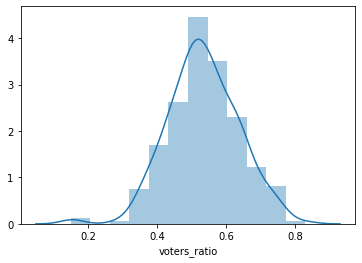

In [52]:
sns.distplot(df_voters_ratio.voters_ratio, bins=12);

## Save Aggregated DataFrame

In [45]:
df_voters_ratio.to_csv('../data/Community_Context/data_voters_ratio.csv')